In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow_addons;
!pip install -q sentencepiece;
!pip install -q tf-models-official;
!pip install -q tensorflow-text;
!pip install -q bert-for-tf2
!pip install -q sentencepiece

     |████████████████████████████████| 1.1 MB 10.0 MB/s 
     |████████████████████████████████| 1.2 MB 12.9 MB/s 
     |████████████████████████████████| 2.2 MB 12.6 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 636 kB 47.7 MB/s 
     |████████████████████████████████| 99 kB 9.7 MB/s 
     |████████████████████████████████| 237 kB 38.0 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
     |████████████████████████████████| 4.9 MB 43.0 MB/s 
     |████████████████████████████████| 352 kB 45.7 MB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
     |████████████████████████████████| 462 kB 54.1 MB/s 
     |████████████████████████████████| 41 kB 135 kB/s 


In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib sizes and settings
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

# TensorFlow libraries
%tensorflow_version 2.x 
import numpy as np
import tensorflow_addons as tfa
import tensorflow as tf
import tensorflow_hub as hub
import keras
import bert
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Base libraries
import matplotlib.pyplot as plt
random_seed = 81
import numpy as np
import pandas as pd
from os import listdir
import string
from tqdm import tqdm
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# Gensim
import gensim

tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [4]:
def print_scores(label, pred):
  print(f'Accuracy_score: {accuracy_score(label, pred):.2f}', 
        f'f1_score: {f1_score(label, pred):.2f}', 
        f'recall_score: {recall_score(label, pred):.2f}', 
        f'precision_score: {precision_score(label, pred):.2f}', sep='\n', end='\n\n')

In [5]:
df_train = pd.read_csv('drive/My Drive/fake/w2v/newdata.csv')
df_train = df_train[['tweet', 'label']]
# df_train = df_train[df_train['text'].apply(lambda x: isinstance(x, str))]
print(df_train.shape)
df_train.head()

(6420, 2)


,tweet,label
0,the cdc currently reports deaths in general th...,1
1,states reported deaths a small rise from last ...,1
2,politically correct woman almost uses pandemic...,0
3,indiafightscorona we have covid testing labora...,1
4,populous states can generate large case counts...,1


In [6]:
df_test = pd.read_csv('drive/My Drive/fake/w2v/newdata_test.csv')
#y_sub = pd.read_csv(abspath_curr+'data/submit.csv')
#y_sub.drop('label', axis=1, inplace=True)
# df_test = df_test[df_test['text'].apply(lambda x: isinstance(x, str))]
print(len(df_test))

2140


In [7]:
print(df_train.shape)
print(df_train.dtypes)

(6420, 2)
tweet    object
label     int64
dtype: object


In [8]:
X_train, X_val, y_train, y_val = train_test_split(df_train[['tweet']], df_train[['label']], test_size=0.2, shuffle=True, random_state=81)

Apply GloVe Embeddings to Tokenized Text

In [9]:
def tokenizer_spacy(df, col, filename):
  # initialize list to be populated with the tokenized answers
  train_tokenized = []
  # Convert answers to a list
  train_list = df[col].values.tolist()
  # Loop through each answer
  for answer in tqdm(train_list):
      # empty string to populate with the chosen tokens
      tokens_joined = ''
      # spacy object pepares sentence to be parsed
      try:
        nlpd = nlp(answer)
        # for each word in answer
        for t in nlpd:
            # check that it is alphabetic, not a stopword, not punctuation and not a space
            if (t.is_alpha) and (not t.is_stop) and (not t.is_punct) and (not t.is_space):
                # if all conditions above are met, covert token back to string, normalize word to its Lemma, lower letter cases and add to empty string with a space behind it to keep words seperate
                tokens_joined += ' '+t.lemma_.lower()
        # append resulting string to the train_tokenized list
        train_tokenized.append(tokens_joined.strip())
      except:
        train_tokenized.append('Not processable')
  # save resulting file in pickle format
  pickle.dump(train_tokenized, open('drive/My Drive/fake/w2v/glove.pkl', 'wb'))
  return train_tokenized

In [10]:
tokenize = True
if tokenize == True:
  X_train_tok = tokenizer_spacy(X_train, 'tweet', 'X_train_tok')
  X_val_tok = tokenizer_spacy(X_val, 'tweet', 'X_val_tok')
  X_test_tok = tokenizer_spacy(df_test, 'tweet', 'X_test_tok')

100%|██████████| 2140/2140 [00:26<00:00, 80.43it/s]


Largest 10 lengths: [5832, 3123, 1449, 372, 316, 312, 289, 278, 273, 268]
median of lengths: 94.0
mean of lengths: 102.18321651090342


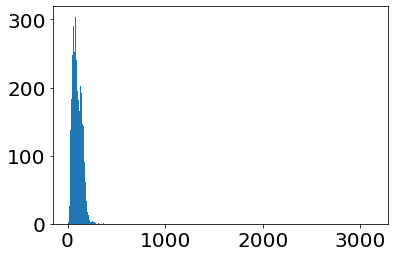

In [11]:
lens = [len(x) for x in X_train_tok]
lens = sorted(lens, reverse=True)
max_len = max(lens)
print('Largest 10 lengths:', lens[0:10])
print('median of lengths:', np.median(lens))
print('mean of lengths:', np.mean(lens))
plt.hist(lens[1:], bins=500)
plt.show()

In [12]:
max_len = 2000

In [13]:
# oov_token='<UNK>'
tok = tf.keras.preprocessing.text.Tokenizer()
tok.fit_on_texts(X_train_tok)
word_index = tok.word_index

train_seq = tok.texts_to_sequences(X_train_tok)
val_seq = tok.texts_to_sequences(X_val_tok)
test_seq =tok.texts_to_sequences(X_test_tok)

X_train_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=max_len)
X_val_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(val_seq, maxlen=max_len)
X_test_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)

In [14]:
word_emb_w2v = {}
file_emb = open("drive/My Drive/fake/w2v/glove.6B.100d.txt", encoding="utf-8")
for emb in tqdm(file_emb):
  array = emb.split()
  word = str(array[0])
  vector = np.asarray(array[1:], dtype=np.float32)
  word_emb_w2v[word] = vector
file_emb.close()

400000it [00:17, 22487.85it/s]


In [15]:
num_o_words = len(word_index)+1
print(num_o_words)
emb_dim = 100 # size of w2v vector
emb_mtrx = np.zeros((num_o_words, emb_dim))

for word, i in word_index.items():
  if i > num_o_words:
    continue
  emb_vector = word_emb_w2v.get(word)
  if emb_vector is not None:
    emb_mtrx[i] = emb_vector

8168


In [16]:
emb_mtrx.shape

(8168, 100)

w2v

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import numpy as np
from nltk.stem import PorterStemmer

In [18]:
!pip install gensim

In [19]:
from gensim.models import Word2Vec

Embedding_dimensions = 200
type(X_train)
#Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [20]:
#Stemming
ps = PorterStemmer()
df_train['tweet'] = df_train['tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

In [21]:
corpus = []
for i in range(0, len(df_train["tweet"])):
  corpus.append(df_train["tweet"][i])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_train["tweet"], df_train['label'],test_size = 0.05, random_state = 98)

In [23]:
from gensim.models import Word2Vec

Embedding_dimensions = 200
type(X_train)
#Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [24]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Vocabulary Length: 2505


In [25]:
input_length = 200
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(corpus)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 9425


In [28]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (6099, 200)
X_test.shape : (321, 200)


In [29]:
from gensim.models import KeyedVectors

In [30]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))
for word, token in tokenizer.word_index.items():
  if word2vec_model.wv.__contains__(word):
      embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix.shape)   

Embedding Matrix Shape: (9425, 200)


In [30]:
#tokenizer.word_index

In [31]:
#word_index

In [31]:
def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

combine w2v and glove

In [32]:
z = merge_two_dicts(tokenizer.word_index, word_index)

In [32]:
len(z)

13036

In [33]:
vocab_length = len(z) + 1
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))
for word, token in z.items():
  if word2vec_model.wv.__contains__(word):
      embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix.shape) 

Embedding Matrix Shape: (13037, 200)


In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding , SimpleRNN

In [46]:
embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)
modela = Sequential()
modela.add(embedding_layer)
modela.add(Bidirectional(LSTM(256)))
modela.add(Dense(1, activation='sigmoid'))
modela.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
modela.summary()

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [47]:
a = modela.fit(X_train, y_train, batch_size=128, epochs=10,verbose=1, validation_split=0.2,callbacks=callbacks)

In [38]:
pred=(modela.predict(X_test) > 0.5).astype("int32")

In [45]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,pred)
acc

TF-IDF

In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [41]:
y=df_train['label']
y.head()
df_train.shape
df = df_train
messages=df.copy()
messages.reset_index(inplace=True)
messages['tweet'][6]

'if you test posit for covid and have no symptom stay home and away from other peopl learn more about cdc’ recommend about when you can be around other after covid infect'

In [42]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(corpus)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 9425


In [43]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [44]:
# clearing and preprocessing
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()

corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]',' ',messages['tweet'][i])
    reivew=review.lower()
    review=review.split()
    
    review =[ps.stem(word)for word in review if not word in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

In [49]:
#corpus

In [45]:
#Apply countvectarizer
# creating the Bag of words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [46]:
X.shape

(6420, 5000)

In [47]:
y=messages['label']

In [52]:
#cv.get_feature_names()[:20]

In [48]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [49]:
X_train1, X_test, y_train, y_test = train_test_split(df_train["tweet"], df_train['label'],test_size = 0.05, random_state = 98)

In [50]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
#tf idf
tf_idf = TfidfVectorizer()
#applying tf idf to training data
#X_train_tf = tf_idf.fit_transform()
#applying tf idf to training data

tf_idf.fit(X_train1)
X_train_tf = tf_idf.transform(X_train1)

#X_train_tf = tf_idf.fit.transform()

In [51]:
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 6099, n_features: 8286


In [52]:
vocabulary=tf_idf.get_feature_names_out()


In [54]:
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),
                ('tfid', TfidfTransformer())]).fit(X_train)

In [64]:
pipe['count'].transform(corpus).toarray()

In [62]:
pipe['tfid'].idf_

In [63]:
idf_m=dict(zip(X_train, pipe['tfid'].idf_))

combine glove,ord2vec,tfidf

In [56]:
zz = merge_two_dicts(z, idf_m)

In [66]:
len(zz)

In [67]:
# Now, we transform the test data into TF-IDF matrix format.

#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(X_test)

print("n_samples: %d, n_features: %d" % X_test_tf.shape)

In [68]:
vocab_length = len(zz) + 1
embedding_matrix1 = np.zeros((vocab_length, Embedding_dimensions))
for word, token in zz.items():
  if word2vec_model.wv.__contains__(word):
      embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix1.shape) 

In [69]:
embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix1], 
                                input_length=input_length,
                                trainable=False)
modela = Sequential()
modela.add(embedding_layer)
modela.add(Bidirectional(LSTM(256)))
modela.add(Dense(1, activation='sigmoid'))
modela.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
modela.summary()

In [70]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

BERT

Data preparation

In [98]:
!pip install transformers
!pip install azureml-core

     |████████████████████████████████| 2.7 MB 11.8 MB/s 
     |████████████████████████████████| 40 kB 5.2 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 211 kB 50.9 MB/s 
     |████████████████████████████████| 178 kB 51.9 MB/s 
     |████████████████████████████████| 1.8 MB 47.9 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 3.6 MB 44.6 MB/s 
     |████████████████████████████████| 85 kB 4.3 MB/s 
     |████████████████████████████████| 146 kB 49.7 MB/s 
     |████████████████████████████████| 412 kB 50.1 MB/s 
     |████████████████████████████████| 2.3 MB 43.3 MB/s 
     |████████████████████████████████| 928 kB 44.3 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 141 kB 50.3 MB/s 
     |██████████████████████

In [99]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/fake/"
os.chdir(path)

Mounted at /content/gdrive


In [100]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch

# saved_model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )
# saved_model.bert.load_state_dict(torch.load('./lqq_transformer1/transformer94.pt'))


saved_model = torch.load('./model')

In [110]:
from transformers import BertTokenizer
import numpy as np

test_text_fake = 'Alfalfa is the only cure for COVID-19.'
test_text_real = '#IndiaFightsCorona India has one of the lowest #COVID19 mortality globally with less than 2% Case Fatality Rate. As a result of supervised home isolation &amp; effective clinical treatment many States/UTs have CFR lower than the national average. https://t.co/QLiK8YPP7E'

tokenizer1 = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

test_text = tokenizer1(list([test_text_fake, test_text_real]), 
                          max_length = 128,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
)
# val_dataset = TensorDataset(encoded_textsValid['input_ids'], encoded_textsValid['attention_mask'], labelsValid)
test_seq = torch.tensor(test_text['input_ids']).to('cuda:0')
test_mask = torch.tensor(test_text['attention_mask']).to('cuda:0')

with torch.no_grad():
  outputs = saved_model(test_seq, test_mask) # reference: https://www.kaggle.com/akshat0007/bert-for-sequence-classification
  pred_proba = outputs[0].detach().cpu().numpy()

preds = np.argmax(pred_proba, axis = 1)

print([preds.tolist(), pred_proba.tolist()])

[[0, 1], [[1.6163028478622437, -0.7679650783538818], [-2.4388601779937744, 2.612088441848755]]]


In [111]:
test_text = tokenizer1(list(df_train["tweet"]), 
                          max_length = 128,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
)

In [104]:
test_seq = torch.tensor(test_text['input_ids']).to('cuda:0')
test_mask = torch.tensor(test_text['attention_mask']).to('cuda:0')

In [37]:
new_feature = merge_two_dicts(tokenizer.word_index, word_index)
vocab_length = len(new_feature) + 1
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))
for word, token in z.items():
  if word2vec_model.wv.__contains__(word):
      embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
#print("Embedding Matrix Shape:", embedding_matrix.shape) 

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding , SimpleRNN

In [39]:
embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)
modela = Sequential()
modela.add(embedding_layer)
modela.add(Bidirectional(LSTM(256)))
modela.add(Dense(1, activation='sigmoid'))
modela.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
modela.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          2607400   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              935936    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 3,543,849
Trainable params: 936,449
Non-trainable params: 2,607,400
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [41]:
a = modela.fit(X_train, y_train, batch_size=128, epochs=10,verbose=1, validation_split=0.2,callbacks=callbacks)

Epoch 1/10
39/39 [==============================] - 18s 205ms/step - loss: 0.6239 - accuracy: 0.6661 - val_loss: 0.5724 - val_accuracy: 0.7131 - lr: 0.0010
Epoch 2/10
39/39 [==============================] - 7s 179ms/step - loss: 0.5775 - accuracy: 0.7067 - val_loss: 0.5892 - val_accuracy: 0.6918 - lr: 0.0010
Epoch 3/10
39/39 [==============================] - 7s 182ms/step - loss: 0.5679 - accuracy: 0.7143 - val_loss: 0.5538 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 4/10
39/39 [==============================] - 7s 185ms/step - loss: 0.5540 - accuracy: 0.7266 - val_loss: 0.5618 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 5/10
39/39 [==============================] - 7s 180ms/step - loss: 0.5391 - accuracy: 0.7325 - val_loss: 0.5192 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
39/39 [==============================] - 7s 180ms/step - loss: 0.5209 - accuracy: 0.7491 - val_loss: 0.5109 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 7/10
39/39 [==============================] - 7s 179ms/step - l

In [42]:
pred=(modela.predict(X_test) > 0.5).astype("int32")

In [43]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,pred)
acc

0.7538940809968847

In [44]:
from sklearn.metrics import classification_report
print(print(classification_report(y_test,pred,target_names=['real','fake'])))

              precision    recall  f1-score   support

        real       0.79      0.70      0.74       164
        fake       0.72      0.81      0.76       157

    accuracy                           0.75       321
   macro avg       0.76      0.76      0.75       321
weighted avg       0.76      0.75      0.75       321

None
